# Simple plenoptic example

Maybe for a quick start? Doesn't show anything complicated, but shows the basics.

In [1]:
import plenoptic as po
import torch
import pyrtools as pt

%matplotlib inline

We need a reference image, so load one in.

/Users/aldebaran/Documents/plenoptic/plenoptic/tools/data.py:90: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  im = color.rgb2gray(im)


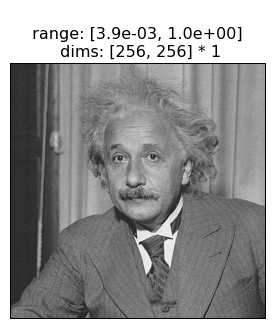

In [3]:
im = po.tools.load_images('../data/256/einstein.pgm')
fig = po.imshow(im)

Models can be really simple, as this demonstrates. It needs to inherit `torch.nn.Module` and just needs two methods: `__init__` (so it's an object) and `forward` (so it can take an image.

In [4]:
## REPLACE WITH CONV OR LN MODEL

class SimpleVisualModel(torch.nn.Module):
    """A simplified RGC model
    """
    def __init__(self, scaling, img_res, min_ecc=.5, max_ecc=15, std_dev=1):
        super().__init__()
        self.PoolingWindows = po.simul.PoolingWindows(scaling, img_res, min_ecc, max_ecc,
                                                     window_type='gaussian', std_dev=std_dev)
        self.representation = None
        
    def forward(self, image):
        self.representation = self.PoolingWindows(image)
        return self.representation

Now we initialize the model and call its forward method

In [5]:
model = SimpleVisualModel(1, im.shape[-2:])
rep = model(im)

We see that `im` is a 4d tensor (batch by channel by height by width) and that our model returns a 3d representation (batch by channel by something). Models need to take in 4d tensors and return 3d or 4d.

In [6]:
print(im.shape)
print(rep.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 465])


And we see it's just a bunch of floats

In [7]:
rep[..., :50]

tensor([[[0.6140, 0.5574, 0.4897, 0.4359, 0.4167, 0.4255, 0.4474, 0.4698,
          0.4793, 0.4686, 0.4368, 0.3975, 0.3821, 0.4017, 0.4428, 0.4921,
          0.5319, 0.5238, 0.4700, 0.4675, 0.5325, 0.5834, 0.5806, 0.5412,
          0.5107, 0.5192, 0.5575, 0.6132, 0.6695, 0.6841, 0.6574, 0.6334,
          0.5646, 0.4991, 0.4820, 0.5116, 0.5513, 0.5773, 0.5855, 0.5750,
          0.5440, 0.4946, 0.4388, 0.3980, 0.3925, 0.4288, 0.4916, 0.5526,
          0.5711, 0.5446]]])

Now initialize the metamer object, which requires the model and the reference image

In [8]:
metamer = po.synth.Metamer(im, model)

And call `synthesize`. This has a handful of optional arguments. You'll probably need to play around with some of the optimization-related ones, like `max_iter`, `learning_rate`, and `optimizer` (see the `Metamer` dosctring or notebook for more info), and you probably want to set `store_progress` to `True` (to store every iteration) or some `int` (to store every `int` iterations) so you can examine synthesis progress.

In [9]:
matched_im, matched_rep = metamer.synthesize(store_progress=True, learning_rate=.1, optimizer='Adam')

100%|██████████| 100/100 [00:09<00:00, 10.83it/s, gradient_norm=1.5397e-01, learning_rate=0.05, loss=3.4771e-02, pixel_change=1.1787e-02]


We can then look at the reference and metamer images:

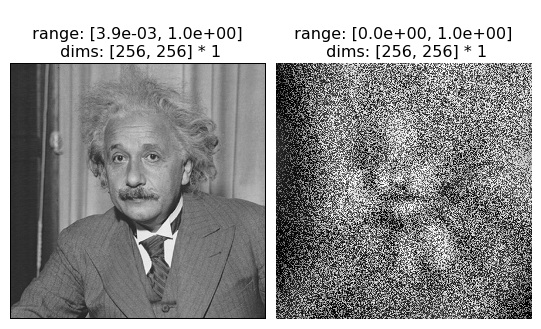

In [10]:
fig = po.imshow([im, matched_im]);

And view a movie of our progress so far

In [11]:
po.convert_anim_to_html(metamer.animate(plot_representation_error=False, figsize=(12, 5)))

In a similar fashion, we can call `MADCompetition`. It requires two models, so we compare it against the `Identity` model, which just returns a copy of the image, and thus is roughly equivalent to using mean-squared error as a metric (we actually use the L2-norm, but you can change that if you'd like)

In [12]:
mad = po.synth.MADCompetition(im, model, po.simul.models.naive.Identity())

And again, call `synthesize`. `MADCompetition` has similar attributes, but one big difference is that its stimuli come in sets of 4, so you have to set the synthesis target (see the `MADCompetition` docstring or notebook for more info).

In [13]:
matched_im, matched_rep_1, matched_rep_2 = mad.synthesize('model_1_min', store_progress=True, optimizer='Adam',)

100%|██████████| 100/100 [00:10<00:00,  9.68it/s, gradient_norm=3.0404e-01, learning_rate=0.00391, loss=6.0437e-02, pixel_change=6.4573e-04, stable_loss=9.9830e-01]


And similarly, we can view an animation to see the progress. Notice there are two losses here, one for each model.

In [ ]:
po.convert_anim_to_html(mad.animate(plot_representation_error=False, figsize=(12, 5)))

/Users/aldebaran/Documents/plenoptic/plenoptic/synthesize/synthesis.py:2192: UserWarning: Looks like representation is image-like, haven't fully thought out how to best handle rescaling color ranges yet!
  warnings.warn("Looks like representation is image-like, haven't fully thought out how"
